In [1]:
import torch

In [ ]:
# train mobile and simple cnn 

In [117]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.optim.lr_scheduler import StepLR


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

class MobileNet(nn.Module):
    def __init__(self):
        super(MobileNet, self).__init__()
        net = models.mobilenet_v3_small(pretrained=False)
        
        self.trunk = nn.Sequential(*(list(net.children())[:-2]))
        
        
        self.avg_pool = nn.AdaptiveAvgPool2d(output_size=1)
        self.fc = nn.Sequential(
            nn.Linear(576, 10, bias=True),
            nn.LogSoftmax(dim=1)
        )
        

    def forward(self, x):
        
        x = self.trunk(x)
        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


def main():
    # Training settings

    no_cuda = False
    seed = 1111
    batch_size = 128
    test_batch_size = 1000
    lr = 0.01
    save_model = True
    epochs = 2
    
    use_cuda = not no_cuda and torch.cuda.is_available()

    torch.manual_seed(seed)

    device = torch.device("cuda" if use_cuda else "cpu")

    train_kwargs = {'batch_size': batch_size,'shuffle':True}
    test_kwargs = {'batch_size': test_batch_size,'shuffle':True}
    if use_cuda:
        cuda_kwargs = {'num_workers': 1,
                       'pin_memory': True,
                       'shuffle': False}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)

    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
    dataset1 = datasets.ImageFolder('mnist/training',transform=transform)
    dataset2 = datasets.ImageFolder('mnist/testing',transform=transform)
    train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs, num_workers=8)
    test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

    model = Net().to(device)
    #model = MobileNet().to(device)
        
    optimizer = optim.SGD(model.parameters(), momentum=0.9, lr=lr)

    scheduler = StepLR(optimizer, step_size=3, gamma=0.1)
    for epoch in range(1, epochs + 1):
        train( model, device, train_loader, optimizer, epoch)
        test(model, device, test_loader)
        scheduler.step()

    if save_model:
        torch.save(model.state_dict(), "mnist_cnn.pt")
        #torch.save(model.state_dict(), "mnist_mobile.pt")
    
    
    return model



In [118]:
model = main()

[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.376692
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.351608
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.127879
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.141902
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.030658

Test set: Average loss: 1.9269, Accuracy: 2719/10000 (27%)



[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.120516
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.067717
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.058179
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.093966
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.102203

Test set: Average loss: 0.0703, Accuracy: 9772/10000 (98%)



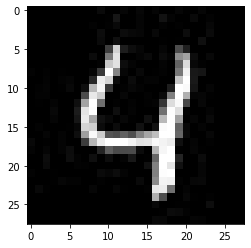

In [56]:
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

four_img = Image.open("mnist/pic/4.jpg")
four_img = four_img.convert('RGB')
transform=transforms.Compose([
        transforms.ToTensor()  
        ])

norm=transforms.Compose([
        transforms.Normalize((0.1307,), (0.3081,))
        ])


four_tensor = transform(four_img)[None,:,:,:]

# plot image (note that numpy using HWC whereas Pytorch user CHW, so we need to convert)
plt.imshow(four_tensor[0].numpy().transpose(1,2,0))


In [57]:

def cnn_eval(tensor):
    model=Net()
    model.load_state_dict(torch.load("mnist_cnn.pt"))
    model.eval()
    print(torch.argmax(model(tensor)))

def mobile_eval(tensor):
    model=MobileNet()
    model.load_state_dict(torch.load("mnist_mobile.pt"))
    model.eval()
    print(torch.argmax(model(tensor)))

mobile_eval(norm(four_tensor))
cnn_eval(norm(four_tensor))

tensor(4)
tensor(4)


In [ ]:
## fgsm to get a wrong prediction

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-5.0219, grad_fn=<NegBackward>)
tensor(9)
None


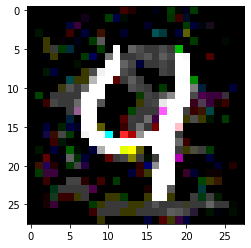

In [60]:
gt = 4
delta = torch.zeros_like(four_tensor, requires_grad=True)
opt = optim.SGD([delta], lr=10)
epsilon = 0.2
for t in range(20):
    pred = model(norm(four_tensor + delta))

    loss = -nn.CrossEntropyLoss()(pred, torch.LongTensor([gt]))
    

    opt.zero_grad()
    loss.backward()
    opt.step()
    delta.data.clamp_(-epsilon, epsilon)
print(loss)
print(cnn_eval(norm(four_tensor + delta)))
plt.imshow(norm(four_tensor + delta)[0].detach().numpy().transpose(1,2,0))


In [ ]:
# pgd more powerful 
# targeted attack: control model to give a target value

8
0 10.68055248260498
50 0.5181572437286377
100 -0.00432741641998291
150 -0.18646281957626343
200 -0.2747672200202942
250 -0.33994150161743164
300 -0.39098554849624634
350 -0.42586851119995117
400 -0.44932180643081665
450 -0.46598124504089355


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True class probability: tensor([[0.0069, 0.0037, 0.0393, 0.0269, 0.1097, 0.0149, 0.0091, 0.0075, 0.5355,
         0.2465]], grad_fn=<SoftmaxBackward>)
tensor(8)


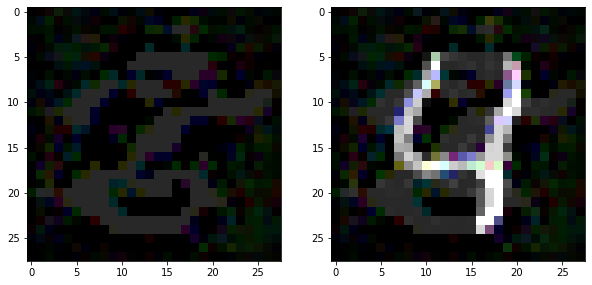

In [109]:
import torch.optim as optim

model.eval()
def l_infinity_pgd(model, tensor, gt,epsilon=40./255, target=None,iteration=500, show=True):
    delta = torch.zeros_like(tensor, requires_grad=True)
    opt = optim.SGD([delta], lr=0.1)
    print(target)
    for t in range(iteration):
        pred = model(norm(tensor + delta))
        if target is None:
            loss = -nn.CrossEntropyLoss()(pred, torch.LongTensor([gt]))
        else:

            loss = - 0.5 * nn.CrossEntropyLoss()(pred, torch.LongTensor([4])) + nn.CrossEntropyLoss()(pred, torch.LongTensor([target]))
        if t % 50 == 0:
            print(t, loss.item())

        opt.zero_grad()
        loss.backward()
        opt.step()
        delta.data.clamp_(-epsilon, epsilon)

    print("True class probability:", nn.Softmax(dim=1)(pred))
    cnn_eval(norm(tensor+delta))

    if show:
        f,ax = plt.subplots(1,2, figsize=(10,5))
        ax[0].imshow((delta)[0].detach().numpy().transpose(1,2,0))
        ax[1].imshow((tensor + delta)[0].detach().numpy().transpose(1,2,0))
    
    return tensor + delta

x= l_infinity_pgd(model,four_tensor,4,target=8)

In [ ]:
## 是不是像才可以？铁男都可以是数字？？？ 其实图片越复杂，对抗扰动就越难以察觉

tensor(7)


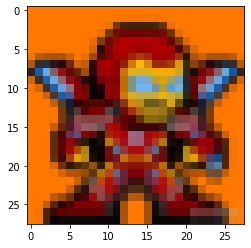

In [110]:
import torch.optim as optim

rem_img = Image.open("mnist/pic/tienan.jpeg")
rem_img = rem_img.convert('RGB')
transform=transforms.Compose([
    transforms.Resize((28,28))  ,
        transforms.ToTensor()  
        ])

norm=transforms.Compose([
        transforms.Normalize((0.1307,), (0.3081,))
        ])


rem_tensor = transform(rem_img)[None,:,:,:]
cnn_eval(norm(rem_tensor))
plt.imshow(rem_tensor[0].numpy().transpose(1,2,0))


6
0 1.6881725788116455
50 0.3029146194458008
100 -0.3654749393463135


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True class probability: tensor([[0.2109, 0.0515, 0.0981, 0.0616, 0.0271, 0.1378, 0.2721, 0.0308, 0.0926,
         0.0175]], grad_fn=<SoftmaxBackward>)
tensor(6)


tensor([[[[ 0.9934,  1.0099,  1.0196,  ...,  1.0278,  1.0009,  0.9963],
          [ 1.0169,  1.0011,  1.0503,  ...,  1.0095,  0.9971,  1.0063],
          [ 0.9940,  0.9676,  1.0499,  ...,  1.0784,  1.0138,  0.9976],
          ...,
          [ 0.9996,  1.0301,  0.8510,  ...,  0.7059,  1.0006,  1.0197],
          [ 1.0001,  0.9985,  0.3360,  ...,  0.3854,  0.9272,  0.9683],
          [ 0.9953,  0.9673,  0.2891,  ...,  0.3312,  0.9422,  0.9790]],

         [[ 0.4795,  0.4780,  0.4950,  ...,  0.4755,  0.4766,  0.4771],
          [ 0.4659,  0.4754,  0.4988,  ...,  0.4691,  0.4627,  0.4897],
          [ 0.4642,  0.4218,  0.4723,  ...,  0.4796,  0.4638,  0.4636],
          ...,
          [ 0.4799,  0.5138,  0.4315,  ...,  0.2980,  0.4940,  0.4876],
          [ 0.4747,  0.4843,  0.1814,  ...,  0.3186,  0.5800,  0.4867],
          [ 0.4767,  0.4588,  0.1434,  ...,  0.2277,  0.4989,  0.4983]],

         [[ 0.0109,  0.0175,  0.0310,  ...,  0.0087,  0.0065,  0.0149],
          [ 0.0090,  0.0088,  

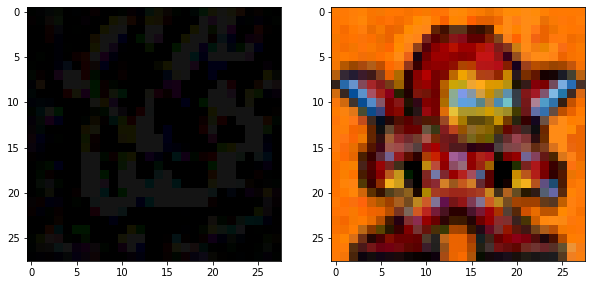

In [112]:

import torch.optim as optim
# 注意修改gt为输出值
pred = 7
l_infinity_pgd(model,rem_tensor,pred,20./255,6,150)

In [ ]:
# 统一视角 各种算法 
# 1) the norm ball perturbation they consider, 
# 2) the method they use for optimizing over that norm ball

In [ ]:
# transfer attack 使用simple cnn产生的攻击样本，对mobile会有影响吗？


In [113]:
# create dataset
import os
from torchvision.utils import save_image
def create_adv_dataset():
    transform=transforms.Compose([
        transforms.ToTensor()
        ])
    dataset1 = datasets.ImageFolder('mnist/training',transform=transform)
    train_loader = torch.utils.data.DataLoader(dataset1,batch_size=1, shuffle=True, num_workers=8)
    
    attack_target = 0 
    # 每个数字生成100个对抗样本
    for batch_idx, (data, target) in enumerate(train_loader):
        attack_target = batch_idx//100
        if target== attack_target:
            continue
        if attack_target>9:
            break
        model=Net()
        model.load_state_dict(torch.load("mnist_cnn.pt"))
        model.eval()
        adv_img = l_infinity_pgd(model,data,target,35./255,attack_target,50,False)
        image_dir_1 = os.path.join('mnist/adv_ori_label',str(target.item()))
        image_dir_2 = os.path.join('mnist/adv_adv_label',str(attack_target))
        if not os.path.exists(image_dir_1):
            os.makedirs(image_dir_1)
        if not os.path.exists(image_dir_2):
            os.makedirs(image_dir_2)
        
        save_image(adv_img, os.path.join(image_dir_1,str(batch_idx)+'.jpg'))
        save_image(adv_img, os.path.join(image_dir_2,str(batch_idx)+'.jpg'))

create_adv_dataset()    

[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNative.cpp:212] Warning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (function set_num_threads)
[W ParallelNati

0
0 6.426124572753906
True class probability: tensor([[5.8821e-05, 1.2473e-05, 9.9949e-01, 3.9094e-04, 1.6212e-07, 1.0766e-07,
         9.5297e-07, 1.4860e-05, 2.7437e-05, 2.9304e-06]],
       grad_fn=<SoftmaxBackward>)
tensor(2)
0
0 5.489558696746826
True class probability: tensor([[1.0127e-04, 7.8590e-06, 3.3023e-04, 4.7346e-04, 3.4414e-07, 1.6575e-04,
         1.4841e-07, 9.9816e-01, 1.0729e-04, 6.5274e-04]],
       grad_fn=<SoftmaxBackward>)
tensor(7)
0
0 4.842442989349365
True class probability: tensor([[1.5377e-03, 2.2881e-05, 9.8199e-05, 1.1315e-04, 7.6687e-06, 1.5902e-02,
         9.7483e-01, 2.5044e-07, 7.4848e-03, 8.4360e-07]],
       grad_fn=<SoftmaxBackward>)
tensor(6)
0
0 8.528207778930664
True class probability: tensor([[2.1308e-03, 4.0438e-04, 4.6232e-04, 5.4251e-03, 8.0053e-04, 9.5760e-01,
         2.5831e-02, 3.7437e-04, 6.6487e-03, 3.2324e-04]],
       grad_fn=<SoftmaxBackward>)
tensor(5)
0
0 8.254728317260742
True class probability: tensor([[1.4738e-04, 2.5104e-04, 9

True class probability: tensor([[1.4589e-04, 8.4638e-05, 2.1302e-02, 2.9672e-03, 8.8284e-08, 8.9599e-04,
         2.3745e-07, 9.7340e-01, 6.4913e-04, 5.5677e-04]],
       grad_fn=<SoftmaxBackward>)
tensor(7)
0
0 16.02664566040039
True class probability: tensor([[0.0028, 0.0015, 0.0070, 0.0026, 0.9346, 0.0025, 0.0035, 0.0065, 0.0056,
         0.0334]], grad_fn=<SoftmaxBackward>)
tensor(4)
0
0 9.020273208618164
True class probability: tensor([[8.9908e-05, 1.5549e-03, 6.5154e-02, 7.2558e-01, 5.8856e-06, 1.3249e-04,
         7.4501e-07, 1.5940e-01, 1.6050e-02, 3.2030e-02]],
       grad_fn=<SoftmaxBackward>)
tensor(3)
0
0 5.663362979888916
True class probability: tensor([[1.0357e-02, 2.4599e-06, 8.5706e-05, 1.0270e-07, 1.6454e-04, 1.9122e-05,
         9.8934e-01, 8.3508e-06, 9.9634e-06, 9.1541e-06]],
       grad_fn=<SoftmaxBackward>)
tensor(6)
0
0 12.24410629272461
True class probability: tensor([[1.0003e-04, 6.7269e-04, 1.5859e-03, 1.0130e-01, 2.8463e-04, 7.6637e-03,
         3.8286e-06, 9

True class probability: tensor([[2.2807e-06, 1.3508e-08, 1.0762e-08, 4.6714e-04, 1.3817e-09, 9.9952e-01,
         6.9497e-07, 1.1173e-08, 1.8948e-06, 1.0529e-05]],
       grad_fn=<SoftmaxBackward>)
tensor(5)
0
0 9.761741638183594
True class probability: tensor([[2.2833e-04, 9.7336e-01, 5.2467e-04, 2.0460e-04, 8.0656e-04, 9.0232e-04,
         1.1700e-02, 4.3365e-04, 1.1401e-02, 4.4132e-04]],
       grad_fn=<SoftmaxBackward>)
tensor(1)
0
0 7.104489326477051
True class probability: tensor([[2.8730e-03, 1.7827e-04, 6.1285e-05, 8.5439e-03, 2.9975e-04, 9.8158e-01,
         1.4815e-03, 7.7016e-04, 3.8181e-03, 3.9560e-04]],
       grad_fn=<SoftmaxBackward>)
tensor(5)
0
0 3.6561994552612305
True class probability: tensor([[2.2403e-01, 5.0980e-04, 5.0646e-02, 6.5760e-01, 4.3209e-05, 2.9576e-02,
         1.3837e-04, 7.7211e-04, 2.6269e-02, 1.0419e-02]],
       grad_fn=<SoftmaxBackward>)
tensor(3)
0
0 5.300993919372559
True class probability: tensor([[3.9875e-04, 4.3267e-04, 2.2717e-02, 1.0566e-02

True class probability: tensor([[5.6579e-05, 2.1127e-03, 4.7746e-05, 2.2639e-04, 3.0120e-06, 6.9705e-03,
         8.2341e-05, 1.1569e-05, 9.9030e-01, 1.9134e-04]],
       grad_fn=<SoftmaxBackward>)
tensor(8)
1
0 8.555377006530762
True class probability: tensor([[1.8996e-04, 4.2243e-02, 5.1622e-05, 3.0200e-03, 6.7131e-01, 3.2507e-03,
         3.1044e-04, 2.4456e-02, 9.9875e-02, 1.5529e-01]],
       grad_fn=<SoftmaxBackward>)
tensor(4)
1
0 11.000886917114258
True class probability: tensor([[1.5610e-06, 2.3158e-06, 6.5111e-07, 2.5572e-03, 5.0612e-08, 9.9625e-01,
         2.9178e-06, 7.8019e-08, 1.1486e-03, 3.8325e-05]],
       grad_fn=<SoftmaxBackward>)
tensor(5)
1
0 6.779186248779297
True class probability: tensor([[9.9442e-01, 1.2999e-04, 2.4231e-03, 4.0714e-04, 7.7206e-06, 6.1936e-04,
         7.3857e-04, 2.5859e-04, 6.7390e-04, 3.1866e-04]],
       grad_fn=<SoftmaxBackward>)
tensor(0)
1
0 6.929294586181641
True class probability: tensor([[1.1393e-04, 5.7121e-02, 2.3667e-03, 2.8235e-01

True class probability: tensor([[3.2131e-04, 4.8482e-05, 2.3210e-03, 3.5701e-03, 2.2562e-06, 3.0825e-04,
         5.2577e-07, 9.8739e-01, 6.5532e-04, 5.3811e-03]],
       grad_fn=<SoftmaxBackward>)
tensor(7)
1
0 5.6849517822265625
True class probability: tensor([[7.1536e-05, 1.2510e-04, 1.2769e-03, 1.6005e-04, 3.0797e-06, 1.5512e-04,
         1.7243e-05, 3.5365e-05, 9.9796e-01, 1.9214e-04]],
       grad_fn=<SoftmaxBackward>)
tensor(8)
1
0 12.248137474060059
True class probability: tensor([[6.3717e-05, 1.0604e-02, 6.8433e-04, 2.2442e-04, 9.7083e-01, 7.2140e-05,
         3.9163e-04, 8.0537e-03, 1.3170e-03, 7.7546e-03]],
       grad_fn=<SoftmaxBackward>)
tensor(4)
1
0 11.711213111877441
True class probability: tensor([[0.0045, 0.0675, 0.0065, 0.0382, 0.8095, 0.0037, 0.0036, 0.0139, 0.0336,
         0.0190]], grad_fn=<SoftmaxBackward>)
tensor(4)
1
0 6.286182403564453
True class probability: tensor([[0.0092, 0.0053, 0.0100, 0.0665, 0.0076, 0.3506, 0.1132, 0.0029, 0.3712,
         0.0635]], 

True class probability: tensor([[1.7741e-02, 4.8755e-05, 3.8422e-03, 6.9145e-05, 9.1068e-04, 1.7705e-03,
         9.7519e-01, 5.9809e-05, 3.3943e-04, 2.9474e-05]],
       grad_fn=<SoftmaxBackward>)
tensor(6)
2
0 4.404458045959473
True class probability: tensor([[8.0062e-03, 8.2311e-03, 3.3513e-02, 2.8971e-03, 7.3147e-04, 1.6220e-01,
         7.5356e-01, 1.4153e-03, 2.9191e-02, 2.5250e-04]],
       grad_fn=<SoftmaxBackward>)
tensor(6)
2
0 13.829729080200195
True class probability: tensor([[4.6598e-05, 2.4688e-04, 5.7160e-04, 7.7412e-02, 2.9231e-04, 2.6995e-03,
         2.4463e-06, 3.4567e-03, 1.2061e-01, 7.9466e-01]],
       grad_fn=<SoftmaxBackward>)
tensor(9)
2
0 2.898667812347412
True class probability: tensor([[2.6229e-03, 5.5323e-05, 1.4090e-01, 1.5538e-03, 9.3365e-07, 3.3638e-04,
         4.5044e-06, 6.9403e-04, 8.5367e-01, 1.6221e-04]],
       grad_fn=<SoftmaxBackward>)
tensor(8)
2
0 9.966700553894043
True class probability: tensor([[0.0072, 0.0062, 0.0436, 0.0340, 0.1927, 0.0198

True class probability: tensor([[0.0063, 0.0018, 0.0025, 0.0075, 0.0067, 0.8870, 0.0050, 0.0060, 0.0294,
         0.0480]], grad_fn=<SoftmaxBackward>)
tensor(5)
2
0 4.902937889099121
True class probability: tensor([[0.0026, 0.4105, 0.1344, 0.0402, 0.0005, 0.0008, 0.0007, 0.0093, 0.3988,
         0.0022]], grad_fn=<SoftmaxBackward>)
tensor(1)
2
0 2.1868667602539062
True class probability: tensor([[2.0240e-05, 1.7864e-03, 1.2694e-01, 8.6703e-01, 2.3986e-06, 5.9993e-05,
         2.7042e-07, 1.3836e-04, 3.8217e-03, 1.9424e-04]],
       grad_fn=<SoftmaxBackward>)
tensor(3)
2
0 7.230584621429443
True class probability: tensor([[3.9908e-06, 3.5476e-06, 1.8093e-03, 1.8019e-05, 3.5127e-05, 8.1815e-04,
         9.9693e-01, 1.4650e-08, 3.8004e-04, 1.3073e-06]],
       grad_fn=<SoftmaxBackward>)
tensor(6)
2
0 6.296916961669922
True class probability: tensor([[2.6120e-06, 2.1601e-06, 3.1564e-04, 1.1581e-04, 1.0333e-08, 2.9668e-05,
         1.0842e-07, 8.4013e-07, 9.9952e-01, 1.0226e-05]],
       gr

True class probability: tensor([[3.6375e-05, 1.1835e-04, 1.5146e-04, 8.2698e-03, 2.5037e-06, 9.2511e-01,
         2.6947e-04, 1.2320e-06, 6.5635e-02, 4.0423e-04]],
       grad_fn=<SoftmaxBackward>)
tensor(5)
2
0 3.456727981567383
True class probability: tensor([[7.8124e-03, 1.5182e-03, 1.1482e-01, 3.0152e-02, 5.2784e-04, 1.5460e-02,
         3.4111e-04, 2.6053e-01, 1.1646e-02, 5.5720e-01]],
       grad_fn=<SoftmaxBackward>)
tensor(9)
2
0 11.924955368041992
True class probability: tensor([[1.0928e-05, 5.3134e-06, 3.4450e-05, 1.8409e-03, 5.5765e-07, 9.9406e-01,
         3.0442e-04, 2.5951e-07, 3.6019e-03, 1.4016e-04]],
       grad_fn=<SoftmaxBackward>)
tensor(5)
2
0 4.439680099487305
True class probability: tensor([[3.4368e-04, 1.3918e-06, 3.1183e-03, 2.2204e-07, 3.1154e-05, 1.8584e-05,
         9.9648e-01, 5.1873e-08, 1.3140e-06, 3.7321e-07]],
       grad_fn=<SoftmaxBackward>)
tensor(6)
2
0 5.701564311981201
True class probability: tensor([[1.9232e-04, 9.4676e-01, 3.3209e-02, 2.6754e-03

True class probability: tensor([[2.3421e-04, 7.2566e-02, 2.2700e-04, 2.7146e-01, 8.7596e-03, 1.7625e-02,
         3.6143e-05, 3.8183e-01, 5.7455e-03, 2.4152e-01]],
       grad_fn=<SoftmaxBackward>)
tensor(7)
3
0 6.512378692626953
True class probability: tensor([[4.6735e-05, 9.8524e-05, 6.2132e-04, 9.3846e-02, 6.4484e-05, 1.1363e-02,
         9.7399e-07, 3.7820e-02, 1.0441e-02, 8.4570e-01]],
       grad_fn=<SoftmaxBackward>)
tensor(9)
3
0 7.792705059051514
True class probability: tensor([[9.8802e-01, 1.6106e-05, 9.2372e-03, 7.7325e-04, 7.6725e-07, 1.1770e-03,
         3.7686e-04, 1.0862e-05, 2.9839e-04, 9.0366e-05]],
       grad_fn=<SoftmaxBackward>)
tensor(0)
3
0 -2.4791946411132812
True class probability: tensor([[5.1458e-07, 2.5969e-06, 2.4795e-03, 2.3673e-02, 3.2392e-10, 1.1587e-06,
         1.4318e-10, 9.7356e-01, 3.2585e-05, 2.5013e-04]],
       grad_fn=<SoftmaxBackward>)
tensor(7)
3
0 5.247824668884277
True class probability: tensor([[9.0121e-01, 1.3454e-04, 6.4766e-02, 1.3013e-0

True class probability: tensor([[1.3451e-06, 2.6159e-08, 3.8237e-08, 9.5341e-03, 5.7021e-09, 9.8938e-01,
         1.5611e-07, 2.4775e-07, 7.7726e-05, 1.0064e-03]],
       grad_fn=<SoftmaxBackward>)
tensor(5)
3
0 2.4849119186401367
True class probability: tensor([[6.1638e-07, 2.5191e-06, 9.7298e-06, 5.8232e-02, 3.9849e-09, 6.4948e-03,
         5.8229e-09, 5.8785e-06, 9.3204e-01, 3.2118e-03]],
       grad_fn=<SoftmaxBackward>)
tensor(8)
3
0 0.4270439147949219
True class probability: tensor([[5.6058e-08, 2.9624e-07, 2.1405e-08, 6.9158e-02, 1.2868e-08, 9.2981e-01,
         1.9715e-08, 1.9079e-08, 3.0219e-04, 7.2677e-04]],
       grad_fn=<SoftmaxBackward>)
tensor(5)
3
0 3.169079303741455
True class probability: tensor([[6.8147e-04, 1.3694e-03, 8.8828e-03, 6.2306e-02, 3.6895e-05, 3.7163e-03,
         1.2542e-05, 9.0408e-01, 3.5981e-03, 1.5314e-02]],
       grad_fn=<SoftmaxBackward>)
tensor(7)
3
0 3.079080581665039
True class probability: tensor([[5.3864e-09, 6.4277e-08, 3.5946e-06, 4.4024e-0

True class probability: tensor([[1.6518e-03, 6.6546e-04, 9.9119e-01, 2.1852e-03, 1.6564e-03, 3.7077e-05,
         1.6881e-03, 2.5862e-04, 4.7804e-04, 1.9287e-04]],
       grad_fn=<SoftmaxBackward>)
tensor(2)
4
0 6.30051326751709
True class probability: tensor([[1.9174e-03, 8.7959e-03, 3.4060e-03, 1.1512e-02, 7.9597e-03, 2.6248e-03,
         8.1290e-03, 4.0931e-04, 9.5353e-01, 1.7133e-03]],
       grad_fn=<SoftmaxBackward>)
tensor(8)
4
0 8.67352294921875
True class probability: tensor([[1.7178e-03, 6.8310e-04, 9.3495e-01, 1.2159e-03, 1.6718e-04, 1.4243e-04,
         3.7453e-04, 5.8907e-02, 8.8033e-04, 9.6116e-04]],
       grad_fn=<SoftmaxBackward>)
tensor(2)
4
0 5.512160301208496
True class probability: tensor([[2.6277e-05, 8.8459e-06, 1.5428e-04, 5.0932e-06, 4.3991e-03, 1.7964e-03,
         9.9271e-01, 1.1256e-07, 8.8602e-04, 1.2095e-05]],
       grad_fn=<SoftmaxBackward>)
tensor(6)
4
0 2.8418376445770264
True class probability: tensor([[0.0171, 0.6213, 0.0052, 0.0020, 0.0604, 0.0020, 

True class probability: tensor([[9.8137e-01, 2.1547e-04, 8.7613e-04, 3.4390e-04, 1.7185e-04, 3.5363e-03,
         4.2870e-03, 6.1628e-03, 6.4524e-04, 2.3882e-03]],
       grad_fn=<SoftmaxBackward>)
tensor(0)
4
0 7.6214165687561035
True class probability: tensor([[1.5352e-03, 3.1802e-03, 1.3858e-01, 1.5772e-02, 1.8101e-04, 5.0107e-04,
         1.5769e-04, 8.3427e-01, 4.8083e-03, 1.0138e-03]],
       grad_fn=<SoftmaxBackward>)
tensor(7)
4
0 9.074458122253418
True class probability: tensor([[1.6428e-04, 1.9166e-04, 1.8751e-02, 3.7395e-02, 1.1560e-05, 1.5052e-04,
         4.6903e-06, 9.4095e-01, 2.1233e-04, 2.1652e-03]],
       grad_fn=<SoftmaxBackward>)
tensor(7)
4
0 8.725323677062988
True class probability: tensor([[3.9907e-05, 4.7402e-03, 2.0418e-03, 9.7881e-01, 1.1421e-04, 6.2613e-04,
         6.5227e-06, 2.1195e-03, 7.0443e-03, 4.4541e-03]],
       grad_fn=<SoftmaxBackward>)
tensor(3)
4
0 6.798157691955566
True class probability: tensor([[0.0020, 0.0070, 0.0726, 0.0135, 0.0429, 0.0044

True class probability: tensor([[5.7418e-01, 5.1585e-04, 1.8763e-03, 1.7850e-03, 9.6956e-03, 2.3116e-01,
         1.5974e-02, 8.6781e-02, 4.5182e-02, 3.2853e-02]],
       grad_fn=<SoftmaxBackward>)
tensor(0)
4
0 7.540604591369629
True class probability: tensor([[7.3231e-04, 8.1408e-05, 3.2298e-04, 1.1553e-02, 1.1402e-03, 8.4889e-01,
         1.5471e-03, 3.4178e-04, 1.2246e-01, 1.2923e-02]],
       grad_fn=<SoftmaxBackward>)
tensor(5)
4
0 7.934573173522949
True class probability: tensor([[2.5734e-05, 4.0378e-03, 1.7570e-03, 4.3498e-03, 1.0311e-04, 4.2978e-05,
         3.5439e-06, 9.8525e-01, 2.6343e-04, 4.1652e-03]],
       grad_fn=<SoftmaxBackward>)
tensor(7)
4
0 7.093754768371582
True class probability: tensor([[1.5594e-04, 3.5258e-03, 1.0394e-04, 9.7937e-05, 3.6848e-04, 7.2137e-03,
         5.6755e-03, 2.2316e-05, 9.8242e-01, 4.1252e-04]],
       grad_fn=<SoftmaxBackward>)
tensor(8)
4
0 5.911381721496582
True class probability: tensor([[5.9265e-05, 6.4275e-06, 5.8262e-04, 2.8134e-06,

True class probability: tensor([[6.1881e-04, 3.6905e-04, 2.2301e-03, 5.7658e-03, 3.1411e-02, 1.1632e-02,
         4.7229e-04, 6.1259e-02, 2.9344e-03, 8.8331e-01]],
       grad_fn=<SoftmaxBackward>)
tensor(9)
5
0 -0.8137807846069336
True class probability: tensor([[8.7120e-02, 1.7829e-05, 3.2411e-04, 1.2903e-05, 2.9612e-07, 4.7513e-01,
         4.3720e-01, 1.1636e-06, 1.8041e-04, 1.3583e-05]],
       grad_fn=<SoftmaxBackward>)
tensor(5)
5
0 6.990797996520996
True class probability: tensor([[5.9328e-05, 3.1425e-04, 2.8283e-04, 5.4539e-03, 6.1507e-02, 6.6035e-01,
         4.6835e-04, 9.9589e-04, 1.5347e-01, 1.1709e-01]],
       grad_fn=<SoftmaxBackward>)
tensor(5)
5
0 16.619705200195312
True class probability: tensor([[4.6887e-04, 7.0138e-04, 5.1573e-04, 5.8259e-04, 8.4988e-01, 4.0900e-03,
         6.9002e-04, 7.4464e-03, 1.6832e-02, 1.1879e-01]],
       grad_fn=<SoftmaxBackward>)
tensor(4)
5
0 10.689166069030762
True class probability: tensor([[3.6689e-05, 1.1833e-05, 9.9976e-01, 1.4837e

True class probability: tensor([[4.8255e-06, 3.3950e-06, 1.5258e-05, 4.8285e-03, 9.0200e-08, 4.0593e-01,
         1.4001e-07, 6.1593e-07, 5.8744e-01, 1.7777e-03]],
       grad_fn=<SoftmaxBackward>)
tensor(8)
5
0 2.562295913696289
True class probability: tensor([[1.6539e-06, 5.0537e-06, 1.6753e-05, 9.7515e-01, 3.8153e-08, 1.7674e-02,
         4.4662e-08, 2.2019e-05, 2.6526e-04, 6.8639e-03]],
       grad_fn=<SoftmaxBackward>)
tensor(3)
5
0 4.447710037231445
True class probability: tensor([[4.2992e-08, 2.6975e-06, 1.5202e-05, 9.8661e-01, 5.0745e-07, 1.2895e-02,
         3.0186e-08, 9.2315e-08, 2.5880e-04, 2.1667e-04]],
       grad_fn=<SoftmaxBackward>)
tensor(3)
5
0 9.145591735839844
True class probability: tensor([[3.9411e-04, 9.6792e-01, 2.3292e-03, 2.1555e-04, 1.0068e-03, 2.9084e-03,
         2.7193e-03, 5.5778e-03, 1.6583e-02, 3.5000e-04]],
       grad_fn=<SoftmaxBackward>)
tensor(1)
5
0 4.4003214836120605
True class probability: tensor([[3.3211e-06, 9.9852e-06, 4.8272e-05, 3.8008e-04

True class probability: tensor([[1.9136e-03, 1.8143e-04, 8.6410e-05, 7.2550e-03, 7.0725e-03, 5.1401e-01,
         1.5935e-03, 9.2485e-03, 1.7336e-03, 4.5690e-01]],
       grad_fn=<SoftmaxBackward>)
tensor(5)
6
0 11.00749397277832
True class probability: tensor([[5.9523e-04, 1.3310e-02, 1.9021e-03, 7.7434e-01, 1.2368e-04, 1.1658e-01,
         1.1166e-04, 3.0961e-03, 6.8982e-02, 2.0964e-02]],
       grad_fn=<SoftmaxBackward>)
tensor(3)
6
0 9.377967834472656
True class probability: tensor([[0.0207, 0.0403, 0.0442, 0.0134, 0.0197, 0.0124, 0.0058, 0.5512, 0.1208,
         0.1715]], grad_fn=<SoftmaxBackward>)
tensor(7)
6
0 6.782064437866211
True class probability: tensor([[1.3263e-04, 3.9364e-06, 2.7367e-07, 8.8271e-06, 2.2201e-07, 9.9816e-01,
         7.1778e-05, 6.9972e-07, 1.6237e-03, 1.7676e-06]],
       grad_fn=<SoftmaxBackward>)
tensor(5)
6
0 4.730337619781494
True class probability: tensor([[1.2645e-03, 1.9131e-03, 2.8317e-03, 9.0919e-05, 9.8076e-04, 4.6800e-04,
         1.1992e-02, 2

True class probability: tensor([[0.0014, 0.0032, 0.0186, 0.0068, 0.0271, 0.0199, 0.0056, 0.0286, 0.3010,
         0.5879]], grad_fn=<SoftmaxBackward>)
tensor(9)
6
0 -1.0682520866394043
True class probability: tensor([[9.8075e-01, 2.5280e-06, 3.4015e-05, 4.1033e-07, 2.8658e-07, 2.2986e-04,
         1.8961e-02, 1.5123e-05, 1.1294e-06, 2.7072e-06]],
       grad_fn=<SoftmaxBackward>)
tensor(0)
6
0 10.956097602844238
True class probability: tensor([[1.3835e-02, 8.8238e-04, 1.6027e-03, 2.8466e-03, 5.7545e-03, 2.5632e-02,
         5.8687e-04, 9.0224e-01, 1.8038e-03, 4.4815e-02]],
       grad_fn=<SoftmaxBackward>)
tensor(7)
6
0 12.99126148223877
True class probability: tensor([[2.1207e-05, 9.4096e-04, 1.8468e-02, 5.9600e-03, 1.0014e-06, 1.7331e-05,
         7.4274e-07, 9.7351e-01, 9.1534e-04, 1.6756e-04]],
       grad_fn=<SoftmaxBackward>)
tensor(7)
6
0 7.158334732055664
True class probability: tensor([[3.4516e-06, 2.3782e-07, 1.1807e-06, 1.3592e-03, 4.6425e-07, 9.9836e-01,
         2.7682e-05

True class probability: tensor([[4.7456e-06, 6.7734e-04, 2.3540e-03, 9.3581e-01, 5.7007e-06, 1.4380e-03,
         1.9102e-06, 2.4454e-04, 5.7826e-02, 1.6366e-03]],
       grad_fn=<SoftmaxBackward>)
tensor(3)
6
0 8.025569915771484
True class probability: tensor([[3.9343e-05, 2.9185e-04, 1.9166e-03, 5.4588e-01, 2.2665e-06, 4.4664e-01,
         1.4236e-04, 7.0186e-06, 5.0353e-03, 4.4282e-05]],
       grad_fn=<SoftmaxBackward>)
tensor(3)
6
0 5.996842384338379
True class probability: tensor([[1.5351e-03, 4.8865e-04, 8.1530e-04, 4.5180e-05, 1.9387e-04, 5.2091e-04,
         1.2058e-03, 1.4350e-04, 9.9497e-01, 8.0040e-05]],
       grad_fn=<SoftmaxBackward>)
tensor(8)
6
0 7.353689193725586
True class probability: tensor([[2.0947e-06, 5.4425e-05, 9.9952e-01, 7.2842e-05, 3.0531e-09, 5.5152e-07,
         3.9954e-05, 8.4943e-08, 3.0546e-04, 3.2827e-09]],
       grad_fn=<SoftmaxBackward>)
tensor(2)
6
0 7.193782329559326
True class probability: tensor([[0.6254, 0.0007, 0.0065, 0.0048, 0.0297, 0.0257,

True class probability: tensor([[9.6219e-07, 4.5292e-08, 5.7300e-06, 1.0625e-03, 2.1514e-07, 1.9423e-04,
         2.0892e-09, 1.3200e-02, 2.6649e-05, 9.8551e-01]],
       grad_fn=<SoftmaxBackward>)
tensor(9)
7
0 6.251029968261719
True class probability: tensor([[2.0933e-09, 1.8795e-05, 1.1569e-03, 9.9874e-01, 1.7284e-09, 1.1781e-07,
         4.0836e-11, 1.4798e-05, 5.9103e-05, 6.2507e-06]],
       grad_fn=<SoftmaxBackward>)
tensor(3)
7
0 3.3723464012145996
True class probability: tensor([[2.1749e-04, 3.2791e-03, 6.8464e-05, 3.6675e-03, 6.6770e-03, 3.8983e-02,
         2.9614e-05, 6.8542e-01, 1.6736e-02, 2.4492e-01]],
       grad_fn=<SoftmaxBackward>)
tensor(7)
7
0 5.143156051635742
True class probability: tensor([[7.7210e-04, 3.3527e-03, 2.6079e-02, 9.4569e-01, 1.0685e-04, 1.3033e-02,
         3.1681e-04, 2.0652e-03, 6.3999e-03, 2.1855e-03]],
       grad_fn=<SoftmaxBackward>)
tensor(3)
7
0 5.446323871612549
True class probability: tensor([[8.9251e-06, 1.4274e-03, 7.4077e-02, 9.2229e-01

True class probability: tensor([[2.1403e-04, 1.2312e-04, 1.0035e-04, 2.2669e-02, 2.2260e-05, 9.5607e-01,
         8.2705e-05, 9.9286e-04, 5.4120e-03, 1.4312e-02]],
       grad_fn=<SoftmaxBackward>)
tensor(5)
7
0 5.6522955894470215
True class probability: tensor([[3.7165e-03, 2.9580e-05, 1.2354e-05, 4.8899e-03, 5.9765e-05, 9.7699e-01,
         2.0135e-04, 1.9142e-03, 7.7891e-04, 1.1409e-02]],
       grad_fn=<SoftmaxBackward>)
tensor(5)
7
0 7.999652862548828
True class probability: tensor([[3.9760e-05, 2.1970e-04, 6.0549e-04, 5.0843e-01, 2.4786e-04, 2.5843e-02,
         1.1909e-06, 5.2825e-04, 1.0666e-01, 3.5742e-01]],
       grad_fn=<SoftmaxBackward>)
tensor(3)
7
0 5.095678329467773
True class probability: tensor([[2.1305e-06, 1.9541e-05, 7.8506e-05, 6.4731e-03, 1.1181e-04, 1.8559e-04,
         2.0812e-08, 7.1451e-02, 1.9290e-03, 9.1975e-01]],
       grad_fn=<SoftmaxBackward>)
tensor(9)
7
0 6.408984661102295
True class probability: tensor([[9.1245e-08, 3.0675e-07, 1.1483e-06, 3.7590e-04

True class probability: tensor([[9.9948e-01, 2.5729e-07, 3.0898e-04, 3.6077e-06, 9.2142e-10, 9.7404e-05,
         7.9739e-06, 2.6154e-05, 6.9897e-05, 5.2099e-06]],
       grad_fn=<SoftmaxBackward>)
tensor(0)
8
0 4.00829553604126
True class probability: tensor([[9.9107e-04, 8.3330e-01, 1.5569e-02, 3.0826e-02, 1.0359e-03, 2.1529e-03,
         4.6300e-04, 2.4547e-02, 7.9522e-02, 1.1592e-02]],
       grad_fn=<SoftmaxBackward>)
tensor(1)
8
0 -0.1101846694946289
True class probability: tensor([[3.0876e-10, 5.0893e-09, 1.3502e-07, 9.9902e-01, 9.2772e-12, 5.2351e-04,
         2.2170e-12, 8.2017e-10, 4.3595e-04, 1.8531e-05]],
       grad_fn=<SoftmaxBackward>)
tensor(3)
8
0 9.281889915466309
True class probability: tensor([[6.5296e-03, 4.8940e-05, 2.7190e-03, 1.8683e-05, 3.4384e-02, 3.8006e-03,
         9.4106e-01, 3.2209e-04, 8.8221e-03, 2.2954e-03]],
       grad_fn=<SoftmaxBackward>)
tensor(6)
8
0 5.045546531677246
True class probability: tensor([[9.5853e-07, 4.1615e-06, 4.8950e-06, 1.6964e-02

True class probability: tensor([[9.9880e-01, 5.2537e-08, 1.0038e-03, 1.4158e-05, 6.2237e-10, 3.7640e-05,
         2.0575e-06, 6.5141e-07, 1.3519e-04, 5.2245e-06]],
       grad_fn=<SoftmaxBackward>)
tensor(0)
8
0 0.2220592498779297
True class probability: tensor([[3.1991e-07, 1.8831e-04, 9.9835e-01, 1.6689e-04, 3.4740e-10, 4.4984e-07,
         5.7996e-08, 1.1399e-03, 1.5446e-04, 8.4506e-08]],
       grad_fn=<SoftmaxBackward>)
tensor(2)
8
0 -1.111145257949829
True class probability: tensor([[4.4386e-03, 6.5783e-03, 1.3044e-02, 5.0305e-03, 5.7611e-05, 3.3693e-01,
         1.2725e-01, 1.6551e-05, 5.0663e-01, 1.9908e-05]],
       grad_fn=<SoftmaxBackward>)
tensor(8)
8
0 3.382164478302002
True class probability: tensor([[1.2556e-03, 6.9614e-01, 1.6787e-02, 7.7789e-05, 2.1464e-04, 3.6527e-04,
         7.1528e-03, 5.7951e-04, 2.7736e-01, 6.4927e-05]],
       grad_fn=<SoftmaxBackward>)
tensor(1)
8
0 1.1319665908813477
True class probability: tensor([[1.0599e-05, 2.3677e-06, 1.1385e-07, 1.2255e-

True class probability: tensor([[2.1787e-05, 4.5531e-04, 2.8002e-01, 4.6102e-01, 5.6739e-08, 4.6107e-05,
         1.7998e-07, 1.9376e-01, 6.4240e-02, 4.4657e-04]],
       grad_fn=<SoftmaxBackward>)
tensor(3)
8
0 1.9619927406311035
True class probability: tensor([[1.6522e-04, 1.4509e-05, 7.6965e-04, 7.0557e-04, 5.9830e-06, 2.4543e-01,
         7.1840e-01, 2.0295e-07, 3.4488e-02, 1.4984e-05]],
       grad_fn=<SoftmaxBackward>)
tensor(6)
8
0 4.915210247039795
True class probability: tensor([[1.5626e-05, 3.8968e-05, 1.2535e-05, 4.4556e-01, 5.9571e-06, 5.4121e-01,
         8.6394e-06, 1.4758e-05, 1.4013e-03, 1.1723e-02]],
       grad_fn=<SoftmaxBackward>)
tensor(5)
8
0 4.235628128051758
True class probability: tensor([[2.5397e-06, 3.0368e-04, 3.3187e-02, 7.4221e-02, 2.4841e-08, 2.1970e-06,
         1.6229e-08, 8.9153e-01, 6.9917e-04, 5.2423e-05]],
       grad_fn=<SoftmaxBackward>)
tensor(7)
8
0 8.003081321716309
True class probability: tensor([[1.5622e-04, 3.7277e-05, 8.6925e-04, 1.9380e-06

True class probability: tensor([[2.2481e-04, 2.7528e-01, 9.8255e-04, 5.1625e-03, 5.1810e-01, 5.2476e-03,
         3.1872e-03, 6.0107e-03, 6.4237e-02, 1.2157e-01]],
       grad_fn=<SoftmaxBackward>)
tensor(4)
9
0 2.5922183990478516
True class probability: tensor([[9.1312e-01, 4.5365e-05, 8.4167e-03, 3.5835e-03, 1.2222e-05, 3.7229e-04,
         1.7286e-05, 1.0679e-02, 2.4845e-03, 6.1268e-02]],
       grad_fn=<SoftmaxBackward>)
tensor(0)
9
0 0.2373967170715332
True class probability: tensor([[1.5522e-06, 2.3073e-06, 1.9510e-05, 5.9999e-01, 1.9154e-07, 3.9048e-01,
         3.0994e-08, 4.4222e-06, 1.8039e-03, 7.6945e-03]],
       grad_fn=<SoftmaxBackward>)
tensor(3)
9
0 4.1573028564453125
True class probability: tensor([[9.9602e-01, 1.2377e-06, 4.5193e-04, 3.8983e-05, 6.8000e-08, 6.6338e-04,
         4.3826e-05, 4.7657e-05, 2.2384e-03, 4.9719e-04]],
       grad_fn=<SoftmaxBackward>)
tensor(0)
9
0 2.704456090927124
True class probability: tensor([[6.6879e-05, 2.5621e-02, 1.8879e-04, 8.0646e-

True class probability: tensor([[1.0738e-04, 1.1445e-04, 5.6115e-04, 3.1429e-05, 1.4346e-02, 2.4646e-03,
         9.7903e-01, 1.0250e-05, 1.0177e-04, 3.2347e-03]],
       grad_fn=<SoftmaxBackward>)
tensor(6)
9
0 6.7614850997924805
True class probability: tensor([[8.7590e-05, 8.2721e-05, 9.9156e-01, 6.3108e-03, 3.4029e-06, 2.2014e-05,
         5.1090e-06, 5.5689e-04, 1.1671e-03, 2.0223e-04]],
       grad_fn=<SoftmaxBackward>)
tensor(2)
9
0 5.9891767501831055
True class probability: tensor([[6.1960e-07, 1.6821e-05, 3.4302e-06, 3.1835e-04, 2.4795e-01, 9.1092e-04,
         2.6537e-05, 8.3019e-05, 9.3526e-03, 7.4133e-01]],
       grad_fn=<SoftmaxBackward>)
tensor(9)
9
0 5.3255157470703125
True class probability: tensor([[1.3794e-05, 1.6609e-04, 6.3229e-01, 3.3382e-01, 1.7768e-08, 1.4505e-05,
         2.6633e-08, 2.4203e-04, 3.3316e-02, 1.3703e-04]],
       grad_fn=<SoftmaxBackward>)
tensor(2)
9
0 4.818833827972412
True class probability: tensor([[9.9830e-01, 2.4323e-06, 9.4570e-04, 2.6763e-

In [119]:

test_transform=transforms.Compose([
        #transforms.GaussianBlur(3, sigma=(0.1, 1.0)),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
  
dataset1 = datasets.ImageFolder('mnist/testing',transform=test_transform)
dataset2 = datasets.ImageFolder('mnist/adv_ori_label',transform=test_transform)
test_loader1 = torch.utils.data.DataLoader(dataset1, shuffle=False,batch_size=100)
test_loader2 = torch.utils.data.DataLoader(dataset2, shuffle=False,batch_size=100)

model=Net()
model.load_state_dict(torch.load("mnist_cnn.pt"))
model.eval()

test(model, 'cpu', test_loader1)
test(model, 'cpu', test_loader2)

model=MobileNet()
model.load_state_dict(torch.load("mnist_mobile.pt"))
model.eval()

test(model, 'cpu', test_loader1)
test(model, 'cpu', test_loader2)




Test set: Average loss: 0.0723, Accuracy: 9762/10000 (98%)


Test set: Average loss: 0.2845, Accuracy: 1540/1705 (90%)


Test set: Average loss: 0.0703, Accuracy: 9772/10000 (98%)


Test set: Average loss: 0.4507, Accuracy: 1478/1705 (87%)



In [ ]:
# adversarial examples may be features train a net using adv_adv_label
# 参看课件

In [ ]:
# defense
# denoise renoise 
# detection 
# adversrial training
